In [2]:
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
import statsmodels.api as sm
plt.style.use('fivethirtyeight')


from sklearn.preprocessing import RobustScaler, MinMaxScaler, MaxAbsScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor


def find_outlier(x):
    q1 = x.describe()['25%']
    q3 = x.describe()['75%']
    iqr = abs(q1-q3)
    bttm_threshold = q1 - (iqr*1.5)
    top_threshold = q3 + (iqr*1.5)
    outlier = [i for i in x if i < bttm_threshold or i > top_threshold]
    outlier_array = np.array(outlier)
    return bttm_threshold, top_threshold, outlier_array


def pretty_print_linear(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name)
                                   for coef, name in lst)

In [3]:
df = pd.read_csv('AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
df1 = df.copy()
df1['price'] = np.log1p(df1['price'])
# Removing Outlier with IQR
bttm_threshold, top_threshold, outlier_array = find_outlier(df1['price'])
bttm_threshold, top_threshold
df1 = df1[(df1['price'] >= bttm_threshold) & (df1['price'] <= top_threshold)] # 637 row deleted

---

In [5]:
df1.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,5.010635,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,5.420535,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,5.017280,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,4.499810,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,4.394449,10,9,2018-11-19,0.10,1,0


In [6]:
df1.fillna(0, inplace=True)
df1.drop(columns=['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'last_review'], inplace=True)
df1.reset_index().head()

,index,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,0,Brooklyn,40.64749,-73.97237,Private room,5.010635,1,9,0.21,6,365
1,1,Manhattan,40.75362,-73.98377,Entire home/apt,5.420535,1,45,0.38,2,355
2,2,Manhattan,40.80902,-73.94190,Private room,5.017280,3,0,0.00,1,365
3,3,Brooklyn,40.68514,-73.95976,Entire home/apt,4.499810,1,270,4.64,1,194
4,4,Manhattan,40.79851,-73.94399,Entire home/apt,4.394449,10,9,0.10,1,0


In [7]:
df1.groupby('neighbourhood_group').mean().sort_values('price', ascending=False)

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
neighbourhood_group,,,,,,,,
Manhattan,40.765351,-73.974403,4.966192,8.535654,21.262922,0.987140,12.932984,110.325552
Brooklyn,40.685064,-73.951130,4.564164,6.025500,24.285206,1.053380,2.285507,99.824007
Queens,40.731606,-73.872903,4.379428,5.048236,27.787551,1.571763,4.070048,143.946976
Staten Island,40.610247,-74.105707,4.360107,4.831522,31.336957,1.582826,2.326087,199.391304
Bronx,40.848266,-73.884547,4.254336,4.574586,26.072744,1.480055,2.230203,165.744015


In [8]:
Temp_dict = {'Bronx': 1, 'Staten Island': 2, 'Queens': 3, 'Brooklyn': 4, 'Manhattan': 5}
df1['neighbourhood_group'] = df1['neighbourhood_group'].map(Temp_dict)
df1.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,4,40.64749,-73.97237,Private room,5.010635,1,9,0.21,6,365
1,5,40.75362,-73.98377,Entire home/apt,5.420535,1,45,0.38,2,355
2,5,40.80902,-73.94190,Private room,5.017280,3,0,0.00,1,365
3,4,40.68514,-73.95976,Entire home/apt,4.499810,1,270,4.64,1,194
4,5,40.79851,-73.94399,Entire home/apt,4.394449,10,9,0.10,1,0


In [9]:
df1.groupby('room_type').mean().sort_values('price', ascending=False)

,neighbourhood_group,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
room_type,,,,,,,,,
Entire home/apt,4.371597,40.728534,-73.960371,5.111421,8.480005,23.107243,1.056324,10.802337,110.418052
Private room,4.100176,40.729189,-73.942829,4.299630,5.308721,24.198010,1.146629,3.226735,110.822520
Shared room,4.079755,40.730496,-73.943379,3.965452,6.453111,16.815074,1.081718,4.705521,162.550394


In [10]:
Temp_dict2 = {'Shared room': 1, 'Private room': 2, 'Entire home/apt': 3}
df1['room_type'] = df1['room_type'].map(Temp_dict2)
df1.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,4,40.64749,-73.97237,2,5.010635,1,9,0.21,6,365
1,5,40.75362,-73.98377,3,5.420535,1,45,0.38,2,355
2,5,40.80902,-73.94190,2,5.017280,3,0,0.00,1,365
3,4,40.68514,-73.95976,3,4.499810,1,270,4.64,1,194
4,5,40.79851,-73.94399,3,4.394449,10,9,0.10,1,0


In [11]:
x = df1.drop(columns=['price'])
y = df1['price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [12]:
kf = KFold(n_splits=5, shuffle=True, random_state=42).get_n_splits()

In [13]:
rfr = RandomForestRegressor(random_state=42)
rfr.fit(x_train, y_train)
y_train_pred = rfr.predict(x_train)
y_test_pred = rfr.predict(x_test)

In [14]:
pd.DataFrame({'Dataset': ['RandomForestRegressor_labelencoder'], 
              'CV error': [ (cross_val_score(rfr, x, y, scoring='neg_root_mean_squared_error',cv=kf).mean())],
              'CV std': [ (cross_val_score(rfr, x, y, scoring='neg_root_mean_squared_error',cv=kf).std())],
              'Training Error' : [np.sqrt(mean_squared_error(y_train, y_train_pred))],
              'Test Error' : [np.sqrt(mean_squared_error(y_test, y_test_pred))],
              'Training_R2_Score' : [r2_score(y_train,y_train_pred)],
              'Test_R2_Score' : [r2_score(y_test,y_test_pred)]
             }).set_index('Dataset')

,CV error,CV std,Training Error,Test Error,Training_R2_Score,Test_R2_Score
Dataset,,,,,,
RandomForestRegressor_labelencoder,-0.402093,0.019274,0.143675,0.375797,0.949455,0.652008


In [15]:
cross_val_score(rfr, x, y, scoring='neg_root_mean_squared_error',cv=kf)

array([-0.39147817, -0.38878148, -0.39590703, -0.39395711, -0.44034303])

In [16]:
cross_val_score(rfr, x, y, scoring='r2',cv=kf)

array([0.54475571, 0.5959109 , 0.59815512, 0.63683719, 0.60910109])

---

In [17]:
x = df1.drop(columns=['price'])
y = df1['price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train = RobustScaler().fit_transform(x_train)
x_test = RobustScaler().fit_transform(x_test)

In [18]:
linear = [LinearRegression(), Lasso(), Ridge(), ElasticNet()]
for i in linear:
    model = i
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f'Model\t = {model}')
    print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}')
    print(f'MAE\t = {round(mean_absolute_error(y_test,y_pred), 2)}')
    print(f'R2 Score = {round( r2_score(y_test,y_pred) * 100 , 2)}')
    print('\n')

Model	 = LinearRegression()
RMSE	 = 0.44
MAE	 = 0.34
R2 Score = 51.71


Model	 = Lasso()
RMSE	 = 0.63
MAE	 = 0.51
R2 Score = 2.13


Model	 = Ridge()
RMSE	 = 0.44
MAE	 = 0.34
R2 Score = 51.71


Model	 = ElasticNet()
RMSE	 = 0.63
MAE	 = 0.51
R2 Score = 2.31




In [22]:
linear = [LinearRegression(), Lasso(), Ridge(), ElasticNet()]
for i in linear:
    model = i
    poly_reg = make_pipeline(
        PF(2, include_bias=False),
        i
    )

    poly_reg.fit(x_train, y_train)
    # predict
    y_pred = poly_reg.predict(x_test)
    print(f'Model\t = {model}')
    print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}')
    print(f'MAE\t = {round(mean_absolute_error(y_test,y_pred), 2)}')
    print(f'R2 Score = {round( r2_score(y_test,y_pred) * 100 , 2)}')
    print('\n')

Model	 = LinearRegression()
RMSE	 = 0.41
MAE	 = 0.31
R2 Score = 57.65


Model	 = Lasso()
RMSE	 = 0.63
MAE	 = 0.51
R2 Score = 2.33


Model	 = Ridge()
RMSE	 = 0.41
MAE	 = 0.31
R2 Score = 57.65


Model	 = ElasticNet()
RMSE	 = 0.62
MAE	 = 0.51
R2 Score = 4.87




In [19]:
ridge = Ridge()
ridge.fit(x_train, y_train)
ridge_y_train_pred = ridge.predict(x_train)
ridge_y_test_pred = ridge.predict(x_test)

In [20]:
pd.DataFrame({'Dataset': ['Ridge'], 
              'CV error': [ (cross_val_score(ridge, x, y, scoring='neg_root_mean_squared_error',cv=kf).mean())],
              'CV std': [ (cross_val_score(ridge, x, y, scoring='neg_root_mean_squared_error',cv=kf).std())],
              'Training Error' : [np.sqrt(mean_squared_error(y_train, ridge_y_train_pred))],
              'Test Error' : [np.sqrt(mean_squared_error(y_test, ridge_y_test_pred))],
              'Training_R2_Score' : [r2_score(y_train,ridge_y_train_pred)],
              'Test_R2_Score' : [r2_score(y_test,ridge_y_test_pred)]
             }).set_index('Dataset')

,CV error,CV std,Training Error,Test Error,Training_R2_Score,Test_R2_Score
Dataset,,,,,,
Ridge,-0.448243,0.013215,0.446694,0.442707,0.511416,0.517057


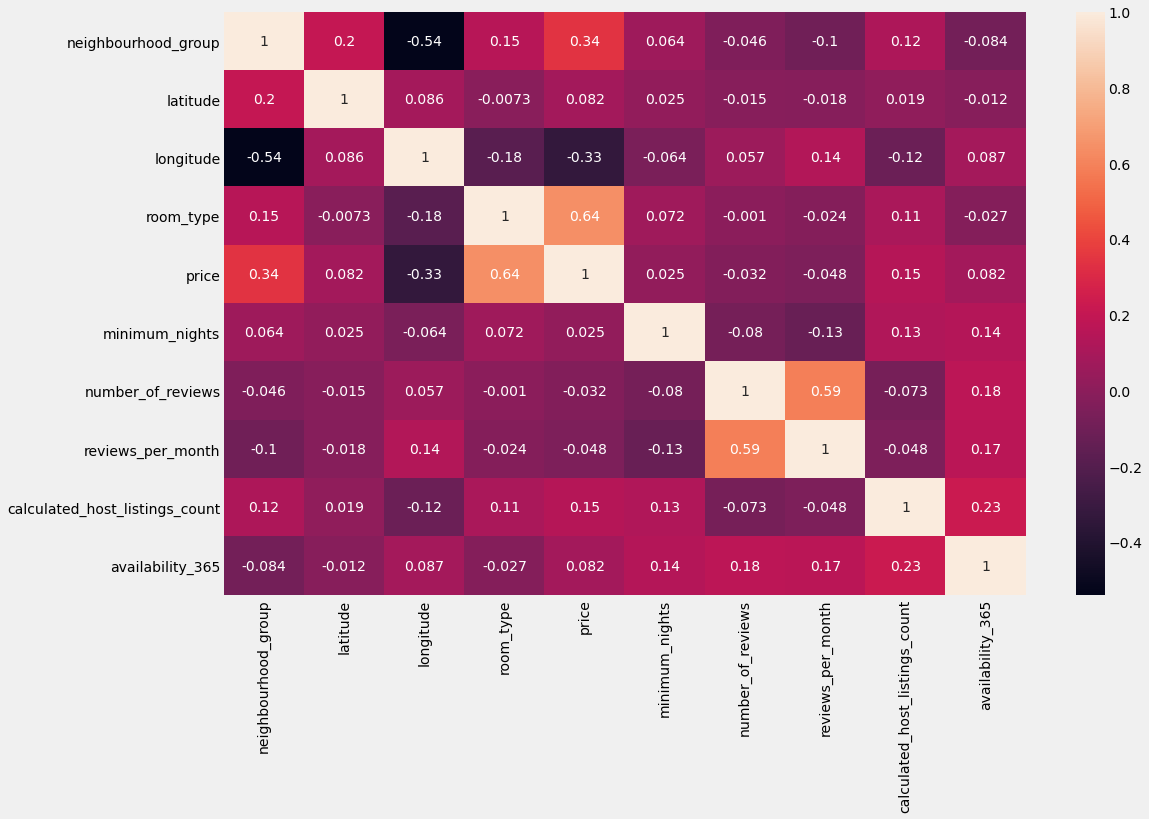

In [21]:
plt.figure(figsize=(16,10))
sns.heatmap(df1.corr(), annot=True);